In [559]:
import os
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from theano.tensor.extra_ops import cumsum
from scipy.stats import percentileofscore as perc_score
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('default')

In [307]:
# Define parameters
fit = int(1e5)
samples = 2000

# Generate test spiking data
length = 100
states = 3
trials = 30
idx = np.arange(length)

# Generate transition times
true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

# Generate state boundaries using transition times
state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

# Generate emission values
n_components = 2
true_lambda = np.random.random((n_components,states))

In [464]:
mean_state_len = np.mean(np.diff(state_inds,axis=-1),axis=None)
print(mean_state_len)

33.333333333333336


In [308]:
# Generate "trials" from 2 different mixture components with uneven mixture probabilities
component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
true_r = np.zeros((trials,length))
for trial in range(trials):
    for state in range(states):
        true_r[trial, state_inds[trial,state]:state_inds[trial,state+1]] = \
                    true_lambda[component_inds[trial],state]
  
# Final spiking data
data_vec = np.random.random(true_r.shape) < true_r

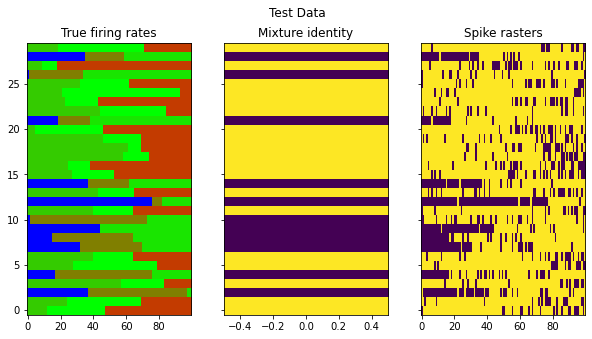

In [394]:
# Visualize test data
fig,ax = plt.subplots(1,3,figsize=(10,5),sharey=True)
ax[1].imshow(component_inds[:,np.newaxis], aspect='auto',origin='lower', interpolation='nearest');
ax[0].imshow(true_r,aspect='auto',origin='lower',cmap='brg', interpolation='nearest');
ax[2].imshow(data_vec,aspect='auto',origin='lower', interpolation='nearest');

fig.suptitle('Test Data');
ax[0].set_title('True firing rates');
ax[1].set_title('Mixture identity');
ax[2].set_title('Spike rasters');

In [310]:
# Calculate mean emission values to initialize parameters
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T

## Single-emission Model

In [515]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = 2
    #b_lambda = 5
    alphas = pm.HalfCauchy('alphas',5,shape=3)
    betas = pm.HalfCauchy('betas',5,shape=3)
    lambda_latent = pm.Beta('lambda', 
                                    #a_lambda, b_lambda, 
                                    alphas, betas,
                                    shape = states,
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [516]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,length))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [517]:
with model:
    lambda_ = tt.tensordot(weight_stack, lambda_latent, [1,0])
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

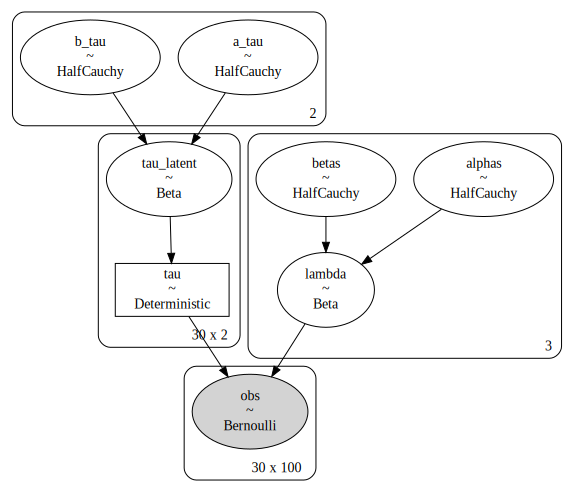

In [518]:
#gv = pm.model_to_graphviz(model)
#gv.format = 'png'
#gv.render(filename='constant_emission_bernoulli')
pm.model_to_graphviz(model)

In [519]:
with model:     
    trace = pm.sample()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda, betas, alphas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
There were 719 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [520]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [521]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
constant_mode_tau = np.copy(mode_tau)

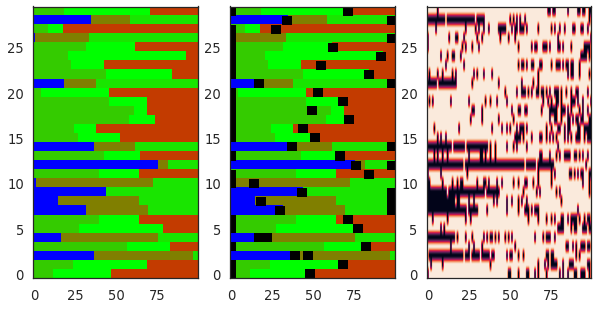

In [522]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
for trial,val in enumerate(mode_tau):
    ax[1].vlines(val, trial-0.5,trial+0.5, linewidth = 10, color='black')
ax[0].imshow(true_r,aspect='auto',origin='lower', cmap='brg', interpolation='nearest')
ax[1].imshow(true_r,aspect='auto',origin='lower', cmap='brg', interpolation='nearest')
ax[2].imshow(data_vec,aspect='auto',origin='lower')
#ax[3].imshow(mean_ppc_obs,aspect='auto',origin='lower');

In [523]:
change_error = np.mean(np.abs(mode_tau-true_tau),axis=0)
total_error = np.mean(np.abs(mode_tau-true_tau),axis=None)
print(change_error)
print(total_error)

[20.93333333 19.6       ]
20.266666666666666


## Catergorical Model

In [524]:
# with pm.Model() as model:
#     w = pm.Dirichlet('w', a=np.ones(n_components)*5, shape = n_components)
    
#     category = pm.Categorical("category", p=w, shape=trials)
#     alphas = pm.HalfCauchy('alphas',5,shape=(n_components,states))
#     betas = pm.HalfCauchy('betas',5,shape=(n_components,states))
    
#     # Hardcode mixture distributions for now
#     clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
#                              pm.Beta('l01',alphas[0,1], betas[0,1]),
#                              pm.Beta('l02',alphas[0,2], betas[0,2])])
#     clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
#                              pm.Beta('l11',alphas[1,1], betas[1,1]),
#                              pm.Beta('l12',alphas[1,2], betas[1,2])])
#     lambdas = tt.stack([clust0_lambda,clust1_lambda])

In [525]:
# with model:   
#     a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
#     b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
#     even_switches = np.linspace(0,1,states+1)[1:-1]
#     tau_latent = pm.Beta('tau_latent', a, b, 
#                          testval = even_switches,
#                          shape = (trials,states-1)).sort(axis=-1)    
    
#     tau = pm.Deterministic('tau', 
#             idx.min() + (idx.max() - idx.min()) * tau_latent)

In [526]:
# with model:   
#     weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
#     weight_stack_shape = weight_stack.tag.test_value.shape
#     weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
#     inverse_stack = 1 - weight_stack[:,1:]
#     inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
#     weight_stack = np.multiply(weight_stack,inverse_stack)

In [527]:
# with model:
#     selected_lambdas = lambdas[category][:,:,np.newaxis]
#     lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)
#     # Add observations
#     observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

In [528]:
# pm.model_to_graphviz(model)

In [529]:
# with model:     
#     trace = pm.sample()

In [530]:
# with model:
#     ppc_trace = pm.sample_posterior_predictive(trace)
# mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [531]:
# tau_samples = trace['tau']
# int_tau = np.vectorize(np.int)(tau_samples)
# mode_tau = stats.mode(int_tau,axis=0)[0][0]

In [532]:
# hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [533]:
# cat_samples = trace['category']
# cat_hist = np.array([np.histogram(trial,bins=np.arange(3))[0] for trial in cat_samples.swapaxes(0,1)])
# inferred_cat = np.round(1-np.mean(cat_samples,axis=0))
# correct_inferred_count = np.sum(component_inds==inferred_cat)

In [534]:
# fig,ax = plt.subplots(2,3,figsize=(10,10))
# ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
# ax[0,1].plot(inferred_cat, np.arange(trials),'-x', label='Inferred')
# ax[0,1].set_title(f'Accuracy = {correct_inferred_count}/{trials}')
# ax[0,1].legend()
# for trial,val in enumerate(mode_tau):
#     ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
# ax[0,0].imshow(true_r,aspect='auto',origin='lower')
# ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
# ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower');
# ax[0,2].imshow(cat_hist,aspect='auto',origin='lower');

In [535]:
# change_error = np.mean(np.abs(mode_tau-true_tau),axis=0)
# total_error = np.mean(np.abs(mode_tau-true_tau),axis=None)
# print(change_error)
# print(total_error)

## Marginalized Model

Sampling would be more efficient if we can use NUTS for all variables.
This can be accomplished by marginalizing out the categorical variables
and using the weights from the Dirichlet distribution to directly weigh
each mixture component for each trial

In [536]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (trials,n_components))
    
    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = tt.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = tt.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = tt.stack([clust0_lambda,clust1_lambda])

In [537]:
with model:   
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [538]:
with model:   
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.tag.test_value.shape
    weight_stack = tt.concatenate([np.ones((weight_stack_shape[0],1,weight_stack_shape[-1])),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((weight_stack_shape[0],1,weight_stack_shape[-1]))],axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [539]:
with model:
    selected_lambdas = tt.tensordot(w,lambdas,[1,0])[:,:,np.newaxis]
    lambda_ = tt.sum(selected_lambdas*weight_stack,axis=1)

In [540]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

In [541]:
gv = pm.model_to_graphviz(model)
gv.format = 'png'
gv.render(filename='bernoulli_mixture_graph')

'bernoulli_mixture_graph.png'

In [542]:
with model:     
    trace = pm.sample()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, b_tau, a_tau, l12, l11, l10, l02, l01, l00, betas, alphas, w, alpha_w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
There were 801 divergences after tuning. Increase `target_accept` or reparameterize.
There were 914 divergences after tuning. Increase `target_accept` or reparameterize.
There were 995 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8924388927954732, but should be close to 0.8. Try to increase the number of tuning steps.
There were 853 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [543]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)
mean_ppc_obs = np.mean(ppc_trace['obs'],axis=0)

In [544]:
tau_samples = trace['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
mixture_mode_tau = np.copy(mode_tau)
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

In [545]:
w_samples = trace['w']
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
mean_w = np.mean(w_samples,axis=0)
categorical_w = np.argmax(mean_w,axis=-1)

In [546]:
cat_accuracy_comparisons = [categorical_w==component_inds,
                      (1-categorical_w)==component_inds]
cat_accuracy_list = [sum(x) for x in cat_accuracy_comparisons]
model_ind = np.int(np.argmax(cat_accuracy_list))
cat_accuracy = cat_accuracy_list[model_ind]

hist_out = np.histogram2d(*w_samples_long.T,bins=50)
diag_vals = np.diag(np.flip(hist_out[0],axis=-1))

components_hist = np.histogram(component_inds,np.arange(3))[0]
components_hist = components_hist/np.max(components_hist)

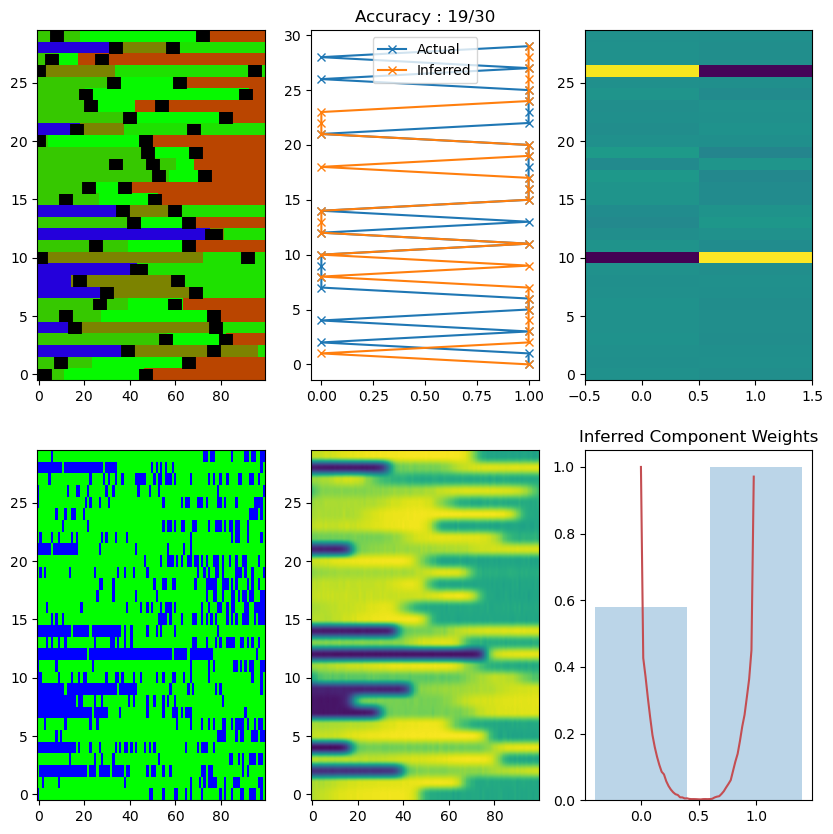

In [560]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,0].imshow(true_r,aspect='auto',origin='lower',vmin=0,vmax=1, cmap = 'brg', interpolation='nearest')
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
ax[0,1].plot(1-categorical_w, np.arange(trials),'-x', label='Inferred')
ax[0,1].set_title(f'Accuracy : {cat_accuracy}/{categorical_w.shape[0]}')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 10, color='black', cmap = 'brg')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower', cmap = 'brg', interpolation='nearest')
ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower',vmin=0,vmax=1);
ax[0,2].imshow(mean_w,aspect='auto',origin='lower');
#plt.colorbar(im = ax[0,2])
ax[1,2].plot(hist_out[1][:-1],diag_vals/np.max(diag_vals),c='r');
ax[1,2].bar([0,1],components_hist, alpha = 0.3);
ax[1,2].set_title('Inferred Component Weights');

In [548]:
change_error = np.mean(np.abs(mode_tau-true_tau),axis=0)
total_error = np.mean(np.abs(mode_tau-true_tau),axis=None)
print(change_error)
print(total_error)

[5.3        6.83333333]
6.066666666666666


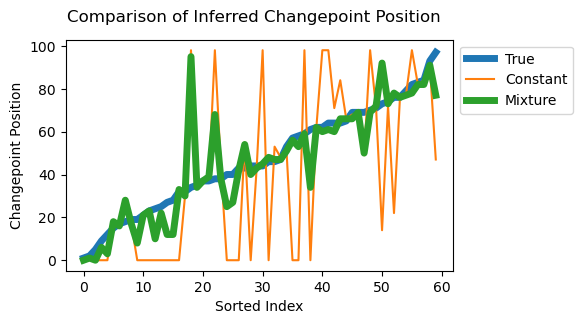

In [568]:
sort_inds = np.argsort(true_tau.flatten())
sort_true = true_tau.flatten()[sort_inds]
sort_constant = constant_mode_tau.flatten()[sort_inds]
sort_mixture = mixture_mode_tau.flatten()[sort_inds]
plt.figure(figsize=(5,3))
plt.plot(sort_true, label = 'True', linewidth = 5)
plt.plot(sort_constant, label = 'Constant')
plt.plot(sort_mixture, label = 'Mixture', linewidth = 5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Changepoint Position')
plt.xlabel('Sorted Index')
plt.suptitle('Comparison of Inferred Changepoint Position')
plt.savefig('compare_changepoint_sorted.png',bbox_inches='tight')

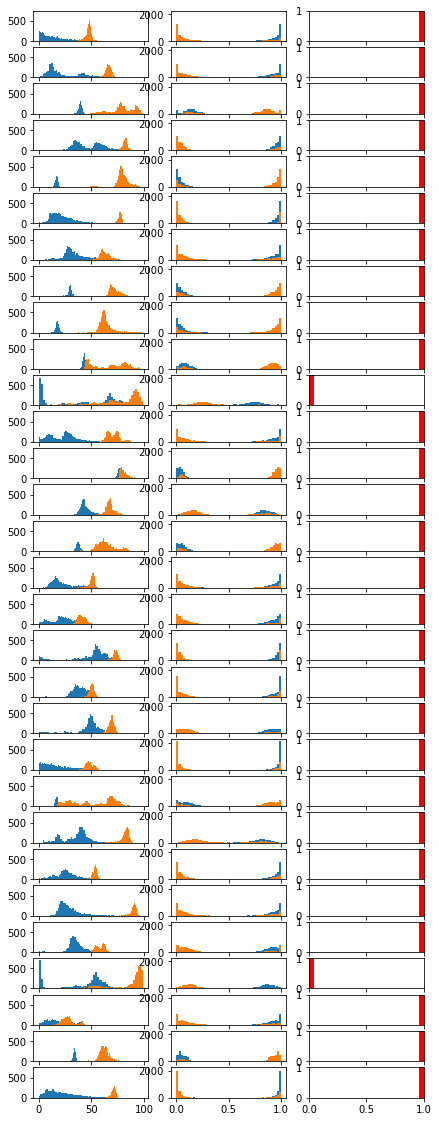

In [475]:
fig,ax = plt.subplots(trials,3, sharex='col', sharey='col', figsize = (7,20))
for this_trial in range(trials):
    for this_state in range(states-1):
        ax[this_trial,0].hist(tau_samples[:,this_trial, this_state], bins = 50)
        ax[this_trial,1].hist(w_samples[:,this_trial, this_state], bins = 50)
        ax[this_trial,2].axvline(cat_accuracy_comparisons[model_ind][this_trial], linewidth = 10, color = 'red')

In [500]:
# Variance of changepoint distributions for error and non-error trials
tau_var = np.var(tau_samples,axis=0)
var_frame = pd.DataFrame({
    'variance' : tau_var.flatten(order='F'),
    'changepoint_ind' : np.sort([1,2]*30),
    'error_trial' : np.tile(cat_accuracy_comparisons[model_ind],2),
    'trial' : np.tile(np.arange(30),2)
})

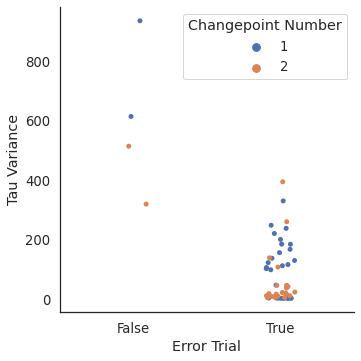

In [513]:
sns.set(font_scale = 1.2)
sns.set_style("white")
g = sns.catplot(data = var_frame, x = 'error_trial', y='variance',hue='changepoint_ind', legend=False)
plt.xlabel('Error Trial')
plt.ylabel('Tau Variance')
plt.legend(title='Changepoint Number')
g.savefig('error_trial_comparison.png',dpi=300)

## Whats the worst we can guess

In [410]:
sorted_random = np.sort(np.random.randint(idx.min(), idx.max(), (10000, *true_tau.shape)),axis=-1)

In [411]:
mean_random_error = np.mean(np.abs(sorted_random - true_tau[np.newaxis,:,:]),axis=(1,2))

In [418]:
constant_emission_error = 19.65
mixture_emission_error = 6.53
constant_emission_perc = perc_score(mean_random_error, constant_emission_error)
mixture_emission_perc = perc_score(mean_random_error, mixture_emission_error)

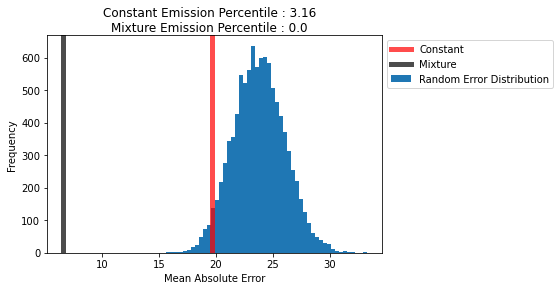

In [431]:
plt.hist(mean_random_error,bins=50, label = 'Random Error Distribution');
plt.axvline(19.65, linewidth = 5, color = 'red', alpha = 0.7, label = 'Constant')
plt.axvline(6.53, linewidth = 5, color = 'black', alpha = 0.7, label = 'Mixture')
plt.suptitle(f'Constant Emission Percentile : {constant_emission_perc}' + '\n' + \
            f'Mixture Emission Percentile : {mixture_emission_perc}')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('random_guess_comparison.png', dpi=300, bbox_inches='tight')